# 📊 Backtesting Naïve Trading Strategies

## Introduction
This notebook explores **backtesting simple trading strategies**, focusing on rule-based approaches such as **moving average crossovers**. We aim to assess the effectiveness of these strategies using historical market data.

To achieve this, we develop a modular framework with two key components:
- **Strategy Class**: Defines trading rules and generates buy/sell signals.
- **Backtest Class**: Simulates trade execution and evaluates trading performance.

## ⚙️ Strategy Class
The `Strategy` class serves as the foundation for implementing various trading strategies. It requires the user to define a method for generating signals based on market data. This allows flexibility in testing different rule-based approaches.

## 🔍 Backtest Engine
The `Backtest` class executes the strategy and tracks performance. It:
- Uses trading signals to determine when to enter and exit positions.
- Keeps track of **cash balance** and **portfolio value**.
- Allows visualization of the **strategy’s performance over time**.

### 📈 Portfolio Simulation
The backtesting engine follows these steps:
1. **Process Trading Signals**: Buy when the strategy signals **1** and sell when the strategy signals **-1**.
2. **Position Management**: Allocate cash to buy assets or liquidate holdings based on signals.
3. **Track Portfolio Value**: Monitor how the value of the strategy evolves over time.

This setup allows us to test and refine different trading strategies efficiently.

In [1]:
import sys
sys.path.append("../")
import Data as dt #! this module is not available in the repository, you can use whatever data you have

import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

---
## **Let's define our base model to hold the different strategies**

In [2]:
class Strategy(ABC):
    def __init__(self):
        # ======= Adapt columns name to the available data / operational consideration =======
        self.date_name = "date"
        self.bid_open_name = "open"
        self.ask_open_name = "open"
        
        # ======= Store Data used for the strategy =======
        self.data = None
        self.processed_data = None
    
    #*____________________________________________________________________________________ #
    def set_names(self, date_name: str, bid_open_name: str, ask_open_name: str):
        """
        Set the names of the columns used in the data, it is important to ensure the operations are done using the correct price. 
        For daily data, it is common to use the open or close price for both bid and ask. The bid-ask spread is usually estimated as a slippage cost.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
        """
        self.date_name = date_name
        self.bid_open_name = bid_open_name
        self.ask_open_name = ask_open_name
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def set_params(self):
        """This method should be used to set the different parameters of the model."""
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def load_data(self):
        """This method should be used to load the data."""
        pass

    #*____________________________________________________________________________________ #
    @abstractmethod
    def process_data(self):
        """
        This method should be used to process the data : normalization, feature engineering, etc.
        It is expected to output a list of pd.DataFrame containing the processed data, each element of the list will then be used independtly to predict the signals.
        For daily data, returning a list containing a unique element is enough. Different elements can be used to avoid overnight bias when operating only intraday.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def fit(self):
        """
        This method should be used to train the model, optimize hyperparameters and so on.
        It does not explicitly split samples, this has to be done by the user before calling this method.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def predict(self):
        """
        This method should be used to predict the signals.
        It is expected to return a pd.DataFrame containing the necessary data to compute the operations (signals, price, date, etc.).
        """
        pass

    #*____________________________________________________________________________________ #
    def operate(self, df: pd.DataFrame):
        """
        This method is common to all strategies and is used to extract the operations from the signals.
        The outputs are the operations (each line corresponds to a different trade) and the signals (each line corresponds to a bar with the associated signal) DataFrames.
        
            - df (pd.DataFrame) : DataFrame containing the data used to extract the operations
        """
        # ======= I. Extract signals =======
        signals_df = self.predict(df=df)
        
        # ======= II. Objects initialization before extracting operations =======
        operations_df = pd.DataFrame(columns=['ID', 'Side', 'Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', 'PnL'])
        
        # II.1 Set first and last signal to 0 to ensure that the operations are closed
        signals_df.reset_index(drop=True, inplace=True)

        signals_df.loc[0, "signal"] = 0
        signals_df.loc[len(signals_df) - 1, "signal"] = 0
        signals_df.loc[len(signals_df) - 2, "signal"] = 0

        # II.2 Extract the Signal Change and the Entry Points
        signals_df["Signal Change"] = signals_df["signal"].diff()
        signals_df["Signal Change"] = signals_df["Signal Change"].shift(1) #! Shifted to avoid look-ahead bias

        entry_points = signals_df[signals_df["Signal Change"] != 0].copy()
        nb_entry = len(entry_points)
        
        # ======= III. Create an Operation for each entry point =======
        sequential_id = 0
        for idx in range(nb_entry - 1):
            # III.1 Extracting rows
            current_row = entry_points.iloc[idx]
            next_row = entry_points.iloc[idx + 1]
            previous_row = signals_df.iloc[current_row.name - 1]

            # III.2 Extract Information for a Long Operation
            if (current_row["Signal Change"] > 0 and previous_row["signal"] == 1):
                side = 1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.ask_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.bid_open_name]
                pnl = (exit_price - entry_price)

            # III.3 Extract Information for a Short Operation
            elif (current_row["Signal Change"] < 0 and previous_row["signal"] == -1):
                side = -1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.bid_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.ask_open_name]
                pnl = (entry_price - exit_price)

            else:
                continue

            # III.4 Append Operation to the DataFrame
            operations_df.loc[sequential_id] = [
                sequential_id,
                side,
                entry_date,
                entry_price,
                exit_date,
                exit_price,
                pnl,
            ]

            # --- New sequential id for the next loop iteration ---
            sequential_id += 1
        
        return operations_df, signals_df



---
## **Now let's define the Backtest Framework**
### *It will take a Strategy as input so every strategy we design could be tested systematically*

In [ ]:
class Backtest():
    def __init__(self, strategy: Strategy, brokerage_cost: float = 0.0, slippage_cost: float = 0.0):
        # ======= Backtest parameters =======
        self.ticker = None
        self.start_date = None
        self.end_date = None
        self.strategy_params = None
        
        self.brokerage_cost = brokerage_cost
        self.slippage_cost = slippage_cost
        
        self.n_jobs = 1
        
        # ======= Strategy inputs=======
        self.strategy = strategy
        self.data = None
        self.processed_data = None

        # ======= Backtest results =======
        self.signals_dfs = None
        self.operations_dfs = None
        self.full_operations_df = None
        self.full_signals_df = None

    #*____________________________________________________________________________________ #
    def set_computingParams(self, date_name: str, bid_open_name: str, ask_open_name: str, n_jobs: int = 1):
        """
        This method is used to set the different parameters to ensure the correct computation of the operations.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
            - n_jobs (int) : number of jobs to run in parallel
        """
        self.strategy.set_names(date_name=date_name, bid_open_name=bid_open_name, ask_open_name=ask_open_name)
        self.n_jobs = n_jobs
    
    #*____________________________________________________________________________________ #
    def set_backtestParams(self, ticker: str, start_date: str, end_date: str, strategy_params: dict):
        """
        This method is used to set the different parameters of the backtest.
        
            - ticker (str) : ticker of the asset to backtest
            - start_date (str) : start date of the backtest
            - end_date (str) : end date of the backtest
            - strategy_params (dict) : parameters of the strategy
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.strategy_params = strategy_params
    
    #*____________________________________________________________________________________ #
    def run_strategy(self):
        """
        This method is used to run the strategy and extract the operations.
        """
        # ======= I. Set up Parameters and Data =======
        self.strategy.set_params(**self.strategy_params)
        data = self.strategy.load_data(self.ticker, self.start_date, self.end_date)
        processed_data = self.strategy.process_data()
        
        # I.2 Store the data
        self.data = data
        self.processed_data = processed_data
        
        # ======= II. Run the Strategy =======
        if self.n_jobs > 1:
            #! Be aware that the strategy should be thread-safe and to keep track of the timestamps to reconstitute the operations later.
            operations_dfs, signals_dfs = Parallel(n_jobs=self.n_jobs)(delayed(self.strategy.operate)(data_group) for data_group in processed_data)
        else:
            operations_dfs = []
            signals_dfs = []
            for data_group in processed_data:
                operations_df, signals_df = self.strategy.operate(data_group)
                operations_dfs.append(operations_df)
                signals_dfs.append(signals_df)
        
        full_operations_df = pd.concat(operations_dfs, ignore_index=True, axis=0)
        full_signals_df = pd.concat(signals_dfs, ignore_index=True, axis=0)
        
        return full_operations_df, full_signals_df, operations_dfs, signals_dfs
    
    #*____________________________________________________________________________________ #
    def apply_slippage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the slippage on the operations by modifying the entry and exit prices.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply slippage on Entry/Exit prices =======
        # II.1 Adjust entry prices
        adjusted_operations_df["Entry_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Entry_Price"] * (1 + self.slippage_cost) if row["Side"] == 1 else row["Entry_Price"] * (1 - self.slippage_cost), axis=1
        )

        # II.2 Adjust exit prices
        adjusted_operations_df["Exit_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Exit_Price"] * (1 - self.slippage_cost) if row["Side"] == 1 else row["Exit_Price"] * (1 + self.slippage_cost), axis=1
        )

        # ======= III. Adjust the PnL =======
        adjusted_operations_df["PnL_Adjusted"] = (adjusted_operations_df["Exit_Price_Adjusted"] - adjusted_operations_df["Entry_Price_Adjusted"]) * adjusted_operations_df["Side"]

        return adjusted_operations_df
    
    #*____________________________________________________________________________________ #
    def apply_brokerage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the brokerage cost on the operations by modifying the PnL.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply brokerage on PnL =======
        adjusted_operations_df["PnL_Adjusted"] = adjusted_operations_df["PnL_Adjusted"] - (self.brokerage_cost * np.abs(adjusted_operations_df["Entry_Price"]))

        return adjusted_operations_df

    #*____________________________________________________________________________________ #
    def run_backtest(self):
        """
        This method is used to run the backtest.
        """
        # ======= I. Run the Strategy =======
        full_operations_df, full_signals_df, operations_dfs, signals_dfs = self.run_strategy()
        full_operations_df = self.apply_slippage(full_operations_df)
        full_operations_df = self.apply_brokerage(full_operations_df)
        
        # ======= II. Compute the Cumulative Returns =======
        # II.1 Without Fees
        full_operations_df['NoFees_strategy_returns'] = full_operations_df['PnL'] / full_operations_df['Entry_Price']
        full_operations_df['NoFees_strategy_cumret'] = (1 + full_operations_df['NoFees_strategy_returns']).cumprod()
        
        # II.2 With Fees
        full_operations_df['strategy_returns'] = full_operations_df['PnL_Adjusted'] / full_operations_df['Entry_Price']
        full_operations_df['strategy_cumret'] = (1 + full_operations_df['strategy_returns']).cumprod()
        
        # II.3 Buy and Hold
        full_operations_df['BuyAndHold_returns'] = (full_operations_df['Exit_Price'] - full_operations_df['Entry_Price']) / full_operations_df['Entry_Price']
        full_operations_df['BuyAndHold_cumret'] = (1 + full_operations_df['BuyAndHold_returns']).cumprod()
        
        # ======= III. Store the results =======
        self.full_operations_df = full_operations_df
        self.full_signals_df = full_signals_df
        self.operations_dfs = operations_dfs
        self.signals_dfs = signals_dfs
        
        return full_operations_df, full_signals_df
        
    #*____________________________________________________________________________________ #
    def plot_strategy(self, by_date: bool = False, BuyAndHold: bool = True, NoFees: bool = True, Fees: bool = True):
        """
        Plots the strategy's cumulative returns based on executed trades.  
        This method intentionally excludes daily portfolio valuation to avoid overestimating result significance.
        """
        # ======= I. Prepare the DataFrame for plotting =======
        plotting_df = self.full_operations_df.copy()

        # ======= II. Initialize the plot =======
        sns.set_style("whitegrid")
        colors = sns.color_palette("husl", 3)
        plt.figure(figsize=(17, 6))
        
        if by_date:
            plotting_df = plotting_df.set_index(plotting_df['Entry_Date'])
            plt.xlabel('Date', fontsize=14, fontweight='bold')
        else:
            plt.xlabel('Number of Trades', fontsize=14, fontweight='bold')
        
        plt.ylabel('Cumulative Returns', fontsize=14, fontweight='bold')
        plt.title('Strategy Performance Comparison', fontsize=16, fontweight='bold')

        # ======= III. Plot the Cumulative Returns =======
        if BuyAndHold:
            plt.plot(plotting_df['BuyAndHold_cumret'], label='Buy and Hold', color=colors[0], linewidth=2)
        if NoFees:
            plt.plot(plotting_df['NoFees_strategy_cumret'], label='Cumulative Returns Without Fees', color=colors[1], linestyle='--', linewidth=1)
        if Fees:
            plt.plot(plotting_df['strategy_cumret'], label='Cumulative Returns Adjusted', color=colors[2], linewidth=2)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    
    #*____________________________________________________________________________________ #
    def plot_
        

In [45]:
def average_features(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the different smoothed series =======
    rolling_average = price_series.rolling(window=window + 1).apply(lambda x: np.mean(x[:window]))

    # ======= II. Convert to pd.Series =======
    rolling_average = pd.Series(rolling_average, index=price_series.index)
    
    # ======= III. Change Name =======
    rolling_average.name = f"average_{window}"

    return rolling_average

In [46]:

#! ==================================================================================== #
#! ====================================== Strategies ================================== #
class simple_MAcrossover(Strategy):
    def __init__(self):
        super().__init__()

        self.window_big = None
        self.window_small = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, window_big: int, window_small: int):
        self.window_big = window_big
        self.window_small = window_small
    
    #*____________________________________________________________________________________ #
    def load_data(self, ticker: str, start_date: str, end_date: str):
        data = dt.load_data(ticker)
        data = data.loc[start_date:end_date]
        
        data['date'] = data.index
        data.reset_index(drop=True, inplace=True)

        self.data = data

        return data
    
    #*____________________________________________________________________________________ #
    def process_data(self):
        data = self.data.copy()
        close_series = data['close']

        moving_average_big = average_features(price_series=close_series, window=self.window_big)
        moving_average_small = average_features(price_series=close_series, window=self.window_small)
        data['MA_big'] = moving_average_big
        data['MA_small'] = moving_average_small

        processed_data = [data]

        self.processed_data = processed_data

        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self):
        pass

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        signals_df['signal'] = 0

        signals_df.loc[signals_df['MA_big'] < signals_df['MA_small'], 'signal'] = 1
        signals_df.loc[signals_df['MA_big'] > signals_df['MA_small'], 'signal'] = -1

        return signals_df

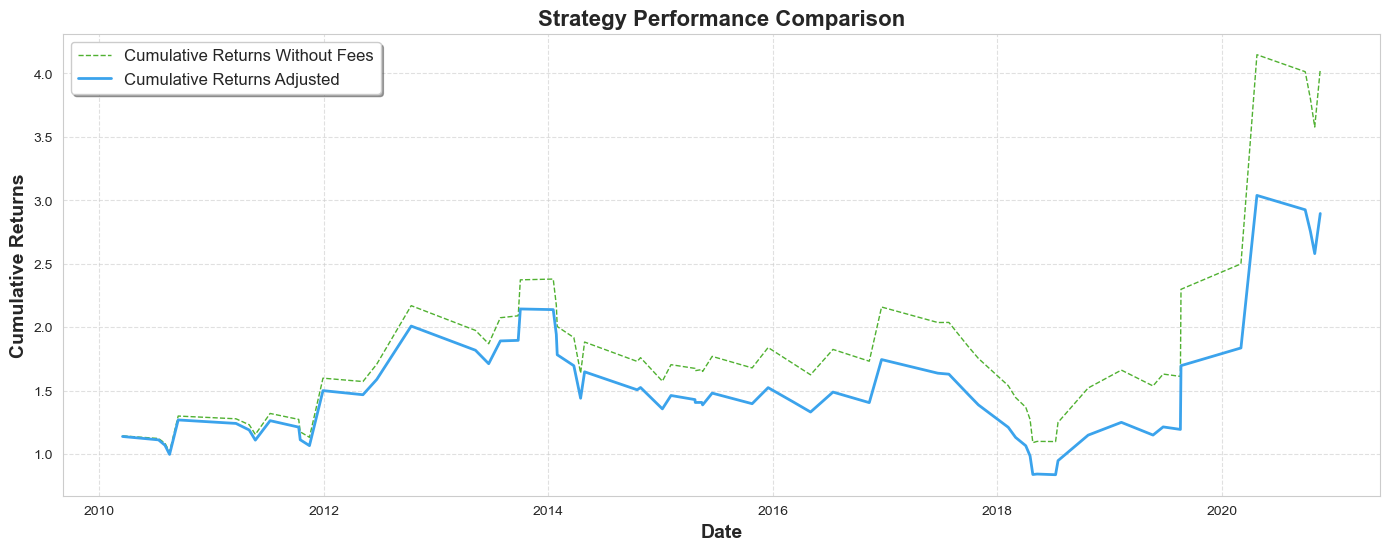

In [50]:
backtest = Backtest(strategy=simple_MAcrossover(), brokerage_cost=0.005, slippage_cost=0.0)
backtest.set_computingParams(date_name='date', bid_open_name='open', ask_open_name='open')
backtest.set_backtestParams(ticker='AAPL', start_date='2010-01-01', end_date='2021-01-01', strategy_params={'window_big': 50, 'window_small': 10})
operations_df, signals_df = backtest.run_backtest()
backtest.plot_strategy(by_date=True, BuyAndHold=False)